## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import kernel_ridge
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.cluster import KMeans
import MDP as mdp

## Read Data

In [2]:
naive_occ_df = pd.read_csv('./data/sdot_12_naive.csv')
gt_occ_df = pd.read_csv('./data/sdot_12_gt.csv')

In [3]:
naive_occ_df.head()

,sourceelementkey,date,hour,paidoccupancy
0,1013,2022-04-29,8,0.25
1,1013,2022-04-29,9,0.25
2,1013,2022-04-29,10,0.50
3,1013,2022-04-29,11,0.00
4,1013,2022-04-29,12,0.25


In [4]:
gt_occ_df.head()

,sourceelementkey,date,hour,paidoccupancy
0,1013,2022-04-29,8,0.50
1,1013,2022-04-29,9,0.00
2,1013,2022-04-29,10,0.25
3,1013,2022-04-29,11,0.00
4,1013,2022-04-29,12,0.25


In [5]:
naive_occ = np.array(naive_occ_df['paidoccupancy'].tolist())
n = naive_occ.shape[0]
naive_occ = naive_occ.reshape((int(n/12), 12))
print('Naive occupancy size:', naive_occ.shape)

Naive occupancy size: (596, 12)


In [6]:
gt_occ = np.array(gt_occ_df['paidoccupancy'].tolist())
n = gt_occ.shape[0]
gt_occ = gt_occ.reshape((int(n/12), 12))
print('Ground truth occupancy size:', gt_occ.shape)

Ground truth occupancy size: (596, 12)


## Preprocess Data

In [7]:
test_ratio = 0.9

In [8]:
x_train, x_test, y_train, y_test = train_test_split(naive_occ, gt_occ, test_size=test_ratio)

In [9]:
print('Training Data Size:', len(x_train))
print('Testing Data Size:', len(x_test))

Training Data Size: 59
Testing Data Size: 537


## Clustering

In [10]:
def group_data(n, X, Y, clusters):
    x_bins = [[] for _ in range(n)]
    y_bins = [[] for _ in range(n)]
    for i, cluster in enumerate(clusters):
        x_bins[cluster].append(X[i])
        y_bins[cluster].append(Y[i])
    return x_bins, y_bins

In [11]:
n_clusters = 3
#gm = GaussianMixture(n_components=n_clusters).fit(x_train)
#clusters = gm.predict(x_train)
kmeans = KMeans(n_clusters, n_init='auto')
kmeans.fit(x_train)
clusters = kmeans.predict(x_train)
x_bins, y_bins = group_data(n_clusters, x_train, y_train, clusters)

In [12]:
# To visualize the data use PCA to reduce dimension to 2 and plot scatter plot
pca = PCA(n_components=2)
pca.fit(x_train)

PCA(n_components=2)

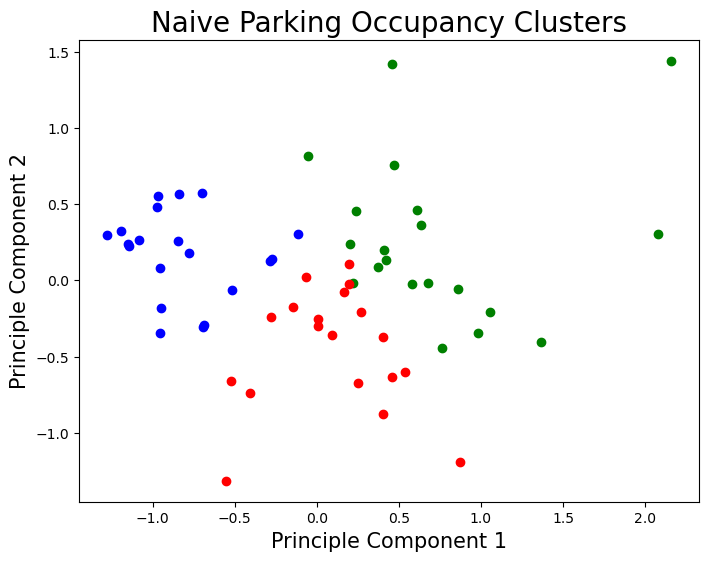

In [13]:
colors = ['b', 'g', 'r', 'm']
plt.figure(figsize=(8,6))
for i, cluster in enumerate(x_bins):
    for point in cluster:
        pca_2d = pca.transform(point.reshape((1,-1)))
        plt.scatter(pca_2d[0,0], pca_2d[0,1], color=colors[i])
plt.title("Naive Parking Occupancy Clusters", fontsize=20)
plt.ylabel("Principle Component 2", fontsize=15)
plt.xlabel("Principle Component 1", fontsize=15)
plt.show()

## Base Case Test

In [14]:
lambda_val = 0.001
gamma = 0.0001
rrg = kernel_ridge.KernelRidge(alpha=lambda_val, kernel='rbf', gamma=gamma)

In [15]:
rrg.fit(x_train, y_train)
y_pred = rrg.predict(x_test)
mae = np.mean(np.abs(y_test-y_pred))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.7275060663264012


In [16]:
mae = np.mean(np.abs(y_test-x_test))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.6948932228045464


## MDP

In [17]:
train_data = (x_bins, y_bins)
test_data = (x_test, y_test)
max_bins = [len(x_bins[i]) for i in range(n_clusters)]
print('max bins:', max_bins)

max bins: [20, 20, 19]


In [24]:
model = mdp.BanditMDP(train_data, test_data, max_bins, lambda_val, gamma)
samples = 20
model.set_goal(samples)

In [25]:
n_iteration = 10000000
for i in tqdm(range(n_iteration)):
    model.run_iteration()

100%|███████████████████████████| 10000000/10000000 [01:19<00:00, 125850.22it/s]


In [26]:
sol = model.get_solution()

curr_state [0, 0, 0]
action: 1
curr_state [1, 0, 0]
action: 1
curr_state [2, 0, 0]
action: 2
curr_state [2, 1, 0]
action: 2
curr_state [2, 2, 0]
action: 2
curr_state [2, 3, 0]
action: 2
curr_state [2, 4, 0]
action: 2
curr_state [2, 5, 0]
action: 2
curr_state [2, 6, 0]
action: 2
curr_state [2, 7, 0]
action: 2
curr_state [2, 8, 0]
action: 2
curr_state [2, 9, 0]
action: 2
curr_state [2, 10, 0]
action: 2
curr_state [2, 11, 0]
action: 2
curr_state [2, 12, 0]
action: 2
curr_state [2, 13, 0]
action: 2
curr_state [2, 14, 0]
action: 2
curr_state [2, 15, 0]
action: 2
curr_state [2, 16, 0]
action: 2
curr_state [2, 17, 0]
action: 3
Solution State [2, 17, 1]
Accuracy 0.7295043378529886


In [31]:
index = np.argsort(sol)[::-1][:2]
print(index)

[1 0]


In [32]:
rlx_train = np.concatenate((x_bins[index[0]], x_bins[index[1]]))
rly_train = np.concatenate((y_bins[index[0]], y_bins[index[1]]))
rrg.fit(rlx_train, rly_train)
y_pred = rrg.predict(x_test)
mae = np.mean(np.abs(y_test-y_pred))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.7363584746434709
